In [1]:
import pandas as pd
from geopy.geocoders import Nominatim
from retrying import retry
import matplotlib.pyplot as plt
import time
import json
import os
import numpy as np

%matplotlib inline

In [2]:
# function to do geocoding
@retry(stop_max_attempt_number=3)
def do_geocode(location,geolocator):
    ''' Function to use geopy to do a geocode, with retry as it fails sometimes
    '''
    res = geolocator.geocode(location,addressdetails=True)
    return res

In [3]:
# read raw data from file
col_names = [
    'starred_at','name','company','email','location','followers','following','url',
    'bio','public_repos','public_gists','blog','created_at','updated_at']
df = pd.read_csv('../data/netdata_gh_data_raw.csv',names=col_names)

# drop dupes
df = df.drop_duplicates()

# strip leading and ending commas
for col in df.columns:
    df[col] = df[col].str[1:].str[:-1]

# dates
for col in ['starred_at','created_at','updated_at']:
    df[col] = pd.to_datetime(df[col].str.replace('"',''))

# ints
for col in ['followers','following','public_repos','public_gists']:
    df[col] = df[col].astype(int)

# clean up location where we removed ','
df['location'] = df['location'].str.replace('  ',', ')

In [4]:
# add email domain 
df['email_domain'] = df['email'].str.split('@').str[-1]

In [5]:
# look at data
print(df.shape)
df.sample(5)

(40000, 15)


,starred_at,name,company,email,location,followers,following,url,bio,public_repos,public_gists,blog,created_at,updated_at,email_domain
20369,2017-05-21 20:45:43,Michael van Tricht,StuComm,michael@tricht.dev,The Netherlands,7,13,https://api.github.com/users/mtricht,Back End Developer @StuComm,13,1,https://tricht.dev,2014-05-07 10:30:46,2019-09-09 19:57:20,tricht.dev
12920,2016-08-21 22:29:43,Bitti,None,None,"Essen, Germany",36,75,https://api.github.com/users/Bitti09,None,21,7,,2010-01-21 16:28:06,2019-09-01 16:26:50,None
5205,2016-04-01 19:48:37,Ning Shi,@zoba,None,None,16,4,https://api.github.com/users/nshi,None,15,6,,2008-05-21 06:29:11,2019-07-11 13:29:20,None
11638,2016-06-09 00:27:25,None,None,None,None,0,0,https://api.github.com/users/BinaryAssault,None,5,0,,2016-06-03 23:31:25,2019-09-06 19:18:08,None
13981,2016-09-19 12:07:18,None,None,zjax-005@163.com,"Hangzhou, Zhejiang, China",9,25,https://api.github.com/users/ugo5,None,39,1,,2012-12-05 09:36:30,2019-08-26 02:38:17,163.com


In [6]:
# add country code via geopy 

# read location to country colde from file if we have one
location_to_country_code_file = 'location_to_country_code.json'
if os.path.exists(location_to_country_code_file):
    with open(location_to_country_code_file, 'r') as f:
        location_to_country_code = json.load(f)
else:
    location_to_country_code = dict()
    
# define geo app
geolocator = Nominatim(user_agent="andrewm4894_dev")

# loop over each unique location
# just do top N due to api limits
locations_todo = df['location'].value_counts().head(250).index.to_list()
for location in locations_todo:
    if location not in location_to_country_code:
        # default to none
        country_code = None
        # fill it in if possible
        if location != None and location != 'None':
            try: 
                geo_res = do_geocode(location,geolocator)
                time.sleep(1)
            except Exception as e: 
                print(e)
                geo_res = None
            if geo_res:
                if 'country_code' in geo_res.raw['address']:
                    country_code = geo_res.raw['address']['country_code']
        location_to_country_code[location] = country_code

# save dict to disk to avoid having to make multiple geopy api calls and hit limits
import json
with open(location_to_country_code_file, 'w') as fp:
    json.dump(location_to_country_code, fp)

# map lookup to col in df
df['country_code'] = df['location'].map(location_to_country_code)

In [7]:
# add starred at date
df['starred_at_date'] = df['starred_at'].dt.date
df['starred_at_yyyymm'] = ((df['starred_at'].dt.year * 100) + df['starred_at'].dt.month).astype(str)

In [8]:
# save data
df.to_csv('../data/netdata_gh_data_clean.csv',index=False)

# look at data
print(df.shape)
df.sample(5)

(40000, 18)


,starred_at,name,company,email,location,followers,following,url,bio,public_repos,public_gists,blog,created_at,updated_at,email_domain,country_code,starred_at_date,starred_at_yyyymm
19879,2017-04-26 07:03:25,Kartik Venkatesh,None,None,"London, UK",6,1,https://api.github.com/users/ammaskartik,Javascript/Kotlin/Swift\r\nRust/Python/Go,40,1,,2013-09-13 14:23:14,2019-07-30 10:13:45,None,gb,2017-04-26,201704
23879,2017-10-16 16:00:43,v,None,None,hidin' entrenched in/above ring0,4,24,https://api.github.com/users/vogelfreiheit,"""Power is always dangerous. Power attracts the...",15,0,,2014-07-09 09:41:22,2019-09-06 13:18:42,None,NaN,2017-10-16,201710
18570,2017-03-08 05:20:57,S1ahs3r,None,None,None,45,201,https://api.github.com/users/Slahser,teaching the repairing of computer at https://...,83,3,https://www.slahser.com,2013-03-04 04:23:53,2019-09-16 15:20:31,None,None,2017-03-08,201703
15102,2016-11-29 11:06:41,fanday,None,None,China Wuxi,6,1,https://api.github.com/users/fanday,NULL,25,2,http://www.jianshu.com/u/74b1ab08fda0,2011-07-05 13:38:47,2019-06-09 08:06:14,None,NaN,2016-11-29,201611
26414,2018-01-28 12:28:22,Willi Gierke,Google,willi.gierke@student.hpi.de,"Mountain View, California",48,16,https://api.github.com/users/WGierke,Software Engineering Intern at Google. Passion...,48,6,https://www.linkedin.com/in/willi-gierke-5221a7b5,2014-02-13 21:25:04,2019-08-26 14:44:03,student.hpi.de,NaN,2018-01-28,201801


In [9]:
# look at top N stargazers by followers
df.sort_values(by='followers',ascending=False).head(25)

,starred_at,name,company,email,location,followers,following,url,bio,public_repos,public_gists,blog,created_at,updated_at,email_domain,country_code,starred_at_date,starred_at_yyyymm
6434,2016-04-04 16:49:45,YaoYuan,None,ibireme@gmail.com,"Beijing, China",10989,57,https://api.github.com/users/ibireme,None,18,1,http://blog.ibireme.com,2011-06-09 06:24:26,2019-06-17 12:18:50,gmail.com,cn,2016-04-04,201604
4481,2016-03-31 23:51:49,Donne Martin,@facebook,donne.martin@gmail.com,"Washington, D.C.",7935,3,https://api.github.com/users/donnemartin,Engineering Manager @facebook. twitter.com/don...,27,0,http://donnemartin.com/,2013-09-14 15:45:40,2019-08-23 08:43:44,gmail.com,NaN,2016-03-31,201603
15303,2016-12-07 19:30:33,Ilya Grigorik,Google,ilya@igvita.com,"San Francisco, CA",7210,153,https://api.github.com/users/igrigorik,Web performance engineer at @Google co-chair ...,72,154,https://www.igvita.com,2008-05-18 05:00:12,2019-09-20 16:13:29,igvita.com,us,2016-12-07,201612
8376,2016-04-11 13:07:11,José Moreira,None,None,"Póvoa de Varzim, Porto, Portugal",7117,129039,https://api.github.com/users/cusspvz,Want to offer me a cup of coffee?\r\nBTC:\r\n1...,124,5,,2013-02-15 16:31:20,2019-09-13 17:17:13,None,NaN,2016-04-11,201604
5222,2016-04-01 20:25:40,Jason Miller,@google,None,"Cambridge, MA",6895,259,https://api.github.com/users/developit,Web DevRel at @Google. Creator of Preact and o...,298,153,https://jasonformat.com,2009-07-15 08:22:03,2019-08-26 00:45:12,None,us,2016-04-01,201604
35786,2019-02-25 03:01:44,DIYgod,@bilibili,i@diygod.me,"Shanghai, China",5852,378,https://api.github.com/users/DIYgod,写代码是热爱，写到世界充满爱！\r\nPowered by love.,73,2,https://diygod.me,2014-07-25 09:27:56,2019-08-26 06:48:32,diygod.me,cn,2019-02-25,201902
4448,2016-03-31 22:55:50,Samy Kamkar,None,git@samy.pl,los angeles,5425,943,https://api.github.com/users/samyk,explo(r|it)ing boundaries,86,8,https://samy.pl,2010-09-22 17:38:55,2019-09-12 16:42:03,samy.pl,NaN,2016-03-31,201603
21607,2017-07-14 04:53:03,安正超,Tencent.,None,Shenzhen China,5381,115,https://api.github.com/users/overtrue,Keep calm and coding.,78,29,http://overtrue.me,2012-02-25 08:17:56,2019-09-02 14:10:50,None,cn,2017-07-14,201707
28592,2018-05-01 00:17:52,Neal Fultz,@njnmco,nfultz@gmail.com,"Los Angeles, CA",5115,1243,https://api.github.com/users/nfultz,Computational statistician programmer and dat...,112,7,https://nfultz.github.io,2010-09-28 04:26:58,2019-08-13 23:43:05,gmail.com,us,2018-05-01,201805
29122,2018-05-27 01:50:49,Michael Straughan,None,None,"Las Vegas, Nevada",5021,60059,https://api.github.com/users/mstraughan86,📱💻 | JavaScript Developer slowly conquering t...,21,17,https://www.linkedin.com/in/mstraughan,2015-09-12 17:27:35,2019-08-12 01:16:42,None,NaN,2018-05-27,201805


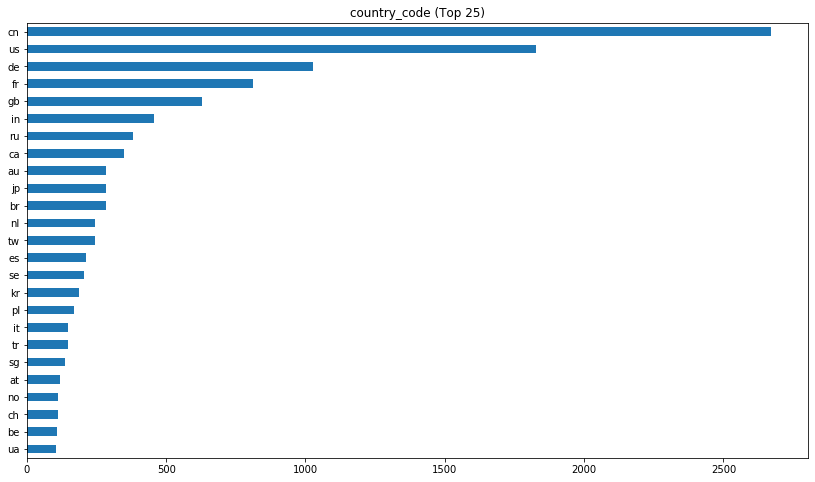

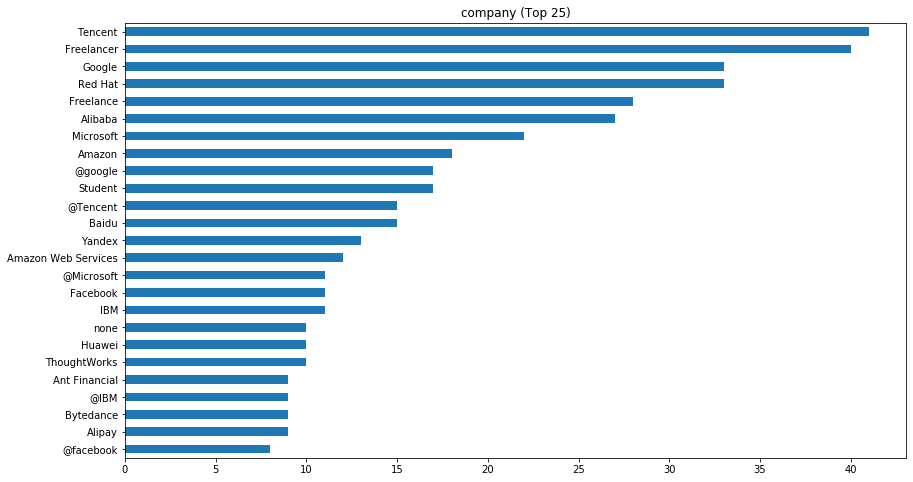

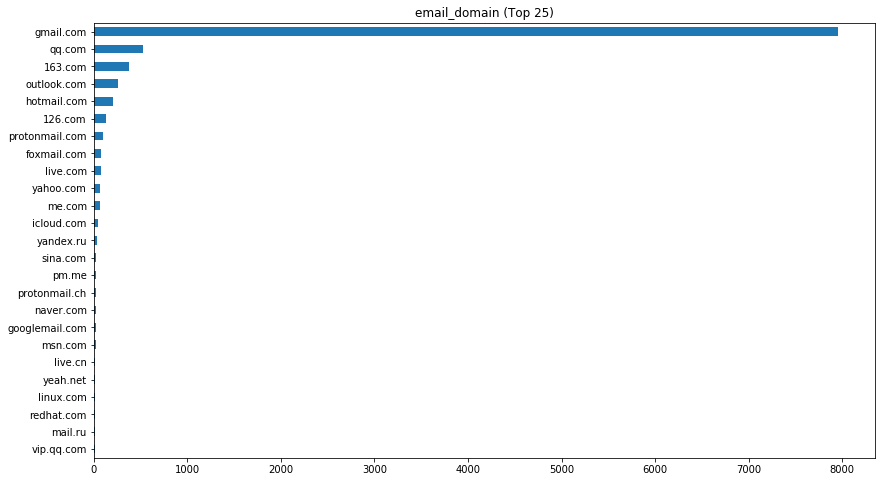

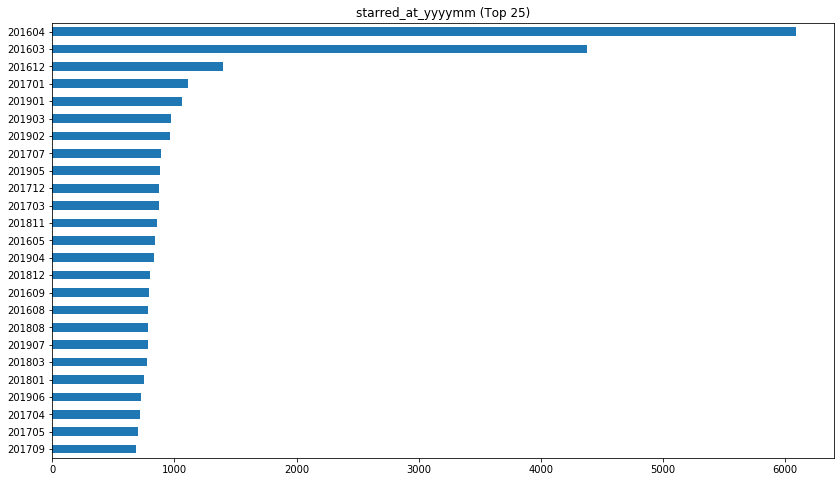

In [10]:
# look at some plots
top_n = 25
for col in ['country_code','company','email_domain','starred_at_yyyymm']:
    ax = df[df[col]!='None'][col].value_counts(dropna=True).head(top_n).sort_values().plot(title=f'{col} (Top {top_n})', kind='barh', figsize=(14,8))
    plt.show()

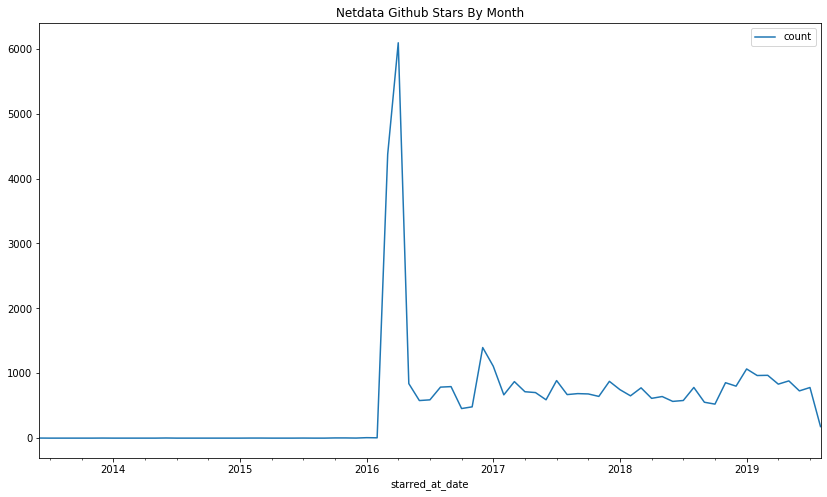

In [11]:
df_tmp = df[['starred_at_date']].copy()
df_tmp['count'] = 1
df_tmp['starred_at_date'] = pd.to_datetime(df_tmp['starred_at_date'])
df_tmp = df_tmp.set_index('starred_at_date')
df_tmp = df_tmp.resample('M').count()
df_tmp.plot(title='Netdata Github Stars By Month',figsize=(14,8))